# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Bayesian Analysis - Contraceptive usage by Bangladeshi Women



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

### Problem: Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset-2-train.csv` and `dataset-2-test.csv` containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order.

In [5]:
# read the datasets
df_train = pd.read_csv('dataset_2_train.csv')
df_test = pd.read_csv('dataset_2_test.csv')

In [6]:
df_train.head()

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0


In [7]:
df_train.shape

(967, 5)

In [8]:
df_train.urban.unique(), df_train['living.children'].unique(), df_train['contraceptive_use'].unique()

(array([0, 1]), array([4, 2, 3, 1]), array([0, 1]))

In [9]:
np.sort(df_train.district.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 55, 56, 57, 58, 59, 60, 61])

In [10]:
#preprocessing step, map the district number 61 to the number 54 so that the districts are in order
df_train.district.replace(61, 54, inplace=True)
np.sort(df_train.district.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60])

To verify the procedure, simulate binary response data assuming the following parameter values (and using the existing features and district information from the training data):

$\mu_{\beta_0} = 2$

$\sigma^2_{\beta_0} = 1$

$\beta_0 \sim N(\mu_{\beta_0},\sigma_{\beta_0}^2)$

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

In [11]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [12]:
mu, sigma = 2, 1
beta0 = np.array(0)
beta0 = np.random.normal(mu, sigma, size=60)
beta1, beta2, beta3 = 4, -3, -2

In [13]:
def var_coe_score(row):
    for i in range(60):
        if row['district']== i+1:
            linpred=beta0[i]+beta1*row['urban']+beta2*row['living.children']+beta3*row['age_mean']  
            p_est=expit(linpred)
    return p_est

In [14]:
df_train['p_est'] = df_train.apply(var_coe_score,axis=1)
df_train['y_sim'] = np.random.binomial(1, df_train['p_est'])

Fit the varying-intercept model specified above to your simulated data.

In [58]:
## for simulated data

bwomen_sim_model_code = '''
model {    
    mu0 ~ dnorm(0, 1/10000);
    inv_sigma0 ~ dgamma(.1,.1);
    
    for (j in 1:J){
        beta0[j] ~ dnorm(mu0, inv_sigma0)
    }
    
    beta1 ~ dnorm(0, 1/10000);
    beta2 ~ dnorm(0, 1/10000);
    beta3 ~ dnorm(0, 1/10000);
    
    
    for (i in 1:N){
        linpred[i] = beta0[id[i]] + beta1*x1[i] + beta2*x2[i] + beta3*x3[i];
        p[i] = ilogit(linpred[i]);
        yhat[i] = p[i];
        y[i] ~ dbern(p[i]);
      }
 }
'''

In [59]:
## for simulated data
id = flatten(np.array(df_train[['district']]))

observed_vals = {'x1': df_train['urban'],
                 'x2': df_train['living.children'],
                 'x3': df_train['age_mean'],
                 'y': df_train['y_sim'],
                 'J': len(df_train.district.unique()),
                 'id': id,
                 'N': df_train.shape[0]}

num_chains = 4
bwomen_model_sim = pyjags.Model(bwomen_sim_model_code, data=observed_vals, chains=num_chains)
burnin = bwomen_model_sim.sample(4000)     #warmup/burn-in
samples_simulated = bwomen_model_sim.sample(7500)   #samples

adapting: iterations 2320 of 4000, elapsed 0:00:10, remaining 0:00:07
adapting: iterations 3484 of 4000, elapsed 0:00:15, remaining 0:00:02
adapting: iterations 4000 of 4000, elapsed 0:00:17, remaining 0:00:00
sampling: iterations 2156 of 16000, elapsed 0:00:10, remaining 0:01:04
sampling: iterations 3240 of 16000, elapsed 0:00:15, remaining 0:01:01
sampling: iterations 5344 of 16000, elapsed 0:00:25, remaining 0:00:51
sampling: iterations 7448 of 16000, elapsed 0:00:35, remaining 0:00:41
sampling: iterations 9552 of 16000, elapsed 0:00:45, remaining 0:00:30
sampling: iterations 11676 of 16000, elapsed 0:00:55, remaining 0:00:20
sampling: iterations 13812 of 16000, elapsed 0:01:04, remaining 0:00:10
sampling: iterations 15952 of 16000, elapsed 0:01:14, remaining 0:00:00
sampling: iterations 16000 of 16000, elapsed 0:01:14, remaining 0:00:00
sampling: iterations 2212 of 30000, elapsed 0:00:10, remaining 0:02:05
sampling: iterations 3324 of 30000, elapsed 0:00:15, remaining 0:02:00
sampl

Plot the trace plots of the MCMC sampler for the parameters $\mu_{\beta_0}, \sigma_{\beta_0}, \beta_1, \beta_2, \beta_3$. Does it look like the samplers converged?

In [60]:
for key, val in enumerate(samples_simulated):
    print(key, val)

0 J
1 N
2 beta0
3 beta1
4 beta2
5 beta3
6 id
7 inv_sigma0
8 linpred
9 mu0
10 p
11 x1
12 x2
13 x3
14 y
15 yhat


In [61]:
def plot_trace(samples, varname, labely, i, burnin_param, entry=0):
    axs[i].plot()
    sample_array = samples[varname]

    vec_len, num_samples, num_chains = sample_array.shape
    for cur_chain in range(num_chains):
        cur_label = "Chain {}".format(cur_chain)
        axs[i].plot(range(num_samples),sample_array[entry,:,cur_chain], label=cur_label)
        axs[i].set_title(labely)
        axs[i].set_ylabel(labely, fontsize=10)
        axs[i].set_xlabel("Iteration", fontsize=10)
    axs[i].axvline(x=burnin_param, linestyle='--', label='burnin')
    axs[i].legend(loc=4, bbox_to_anchor=(1, -0.2), ncol=5)
    plt.tight_layout()

In [62]:
# We have inverse sigma or variance on running the pyjags model
sigma0 = np.reciprocal(np.sqrt(samples_simulated['inv_sigma0']))
samples_simulated['sigma0'] = sigma0

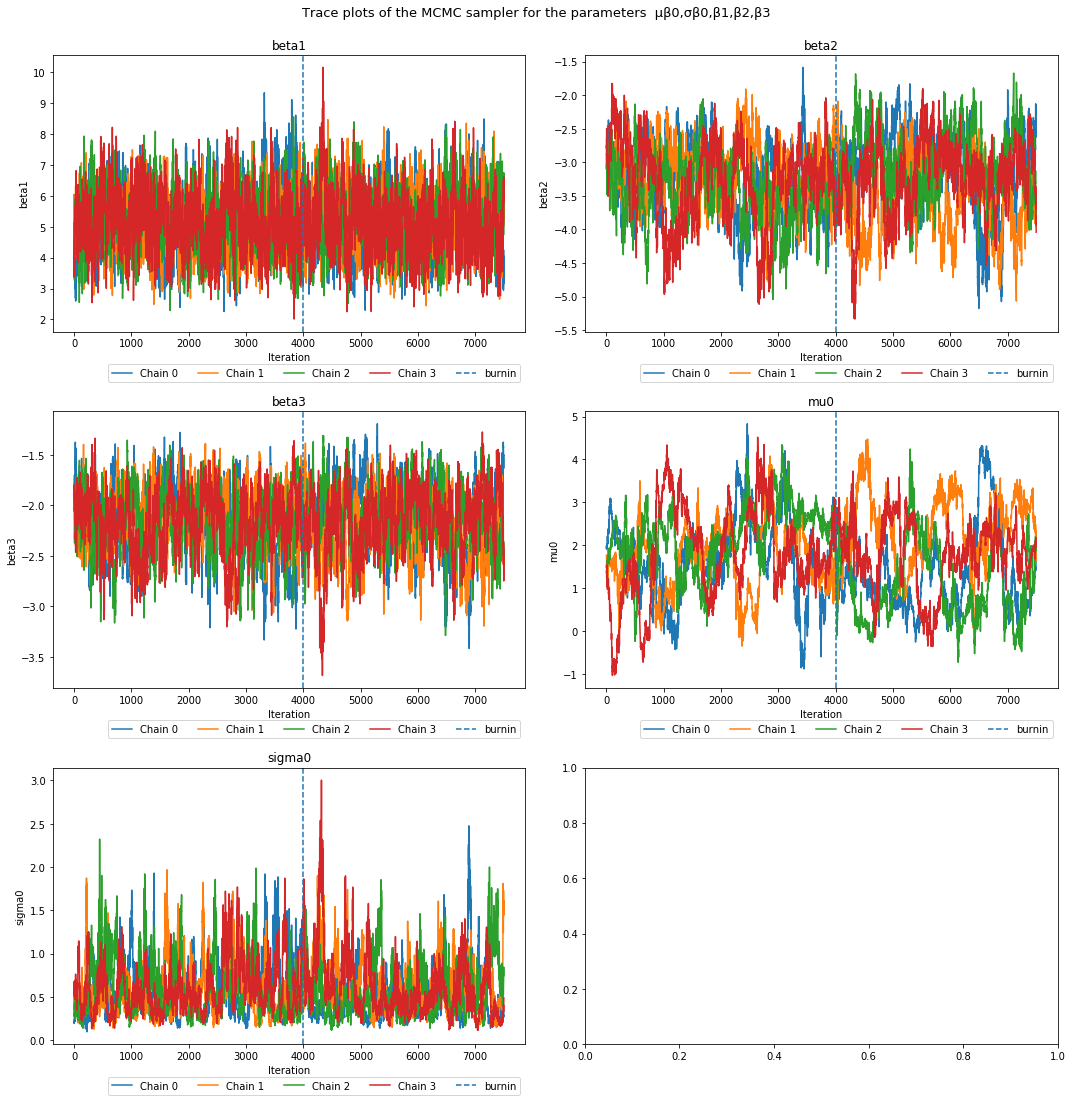

In [81]:
#trace plots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
axs=[ax1,ax2,ax3,ax4,ax5,ax6]
y_param = ['beta1', 'beta2', 'beta3', 'mu0', 'sigma0']

fig.suptitle('Trace plots of the MCMC sampler for the parameters  μβ0,σβ0,β1,β2,β3', fontsize=13, va='top', y=1.02)
for i in range(5):
    axs[i]=plot_trace(samples_simulated, y_param[i], y_param[i], i, burnin_param=4000)

**Answer**
With 7500 samples and 4 MCMC chains, 'mu0' is not converging at all, while the 'beta2', 'beta3' and 'sigma' are close to convergence. 'beta0' is more to convergence. 'beta1' has converged. We can conclude that with simulated data it is taking a longer time to converge.

Plot histograms of the posterior distributions for the parameters $\beta_{0,10}$, $\beta_{0,20}$,...,$\beta_{0,60}$. Are the actual parameters that you generated contained within these posterior distributions? 

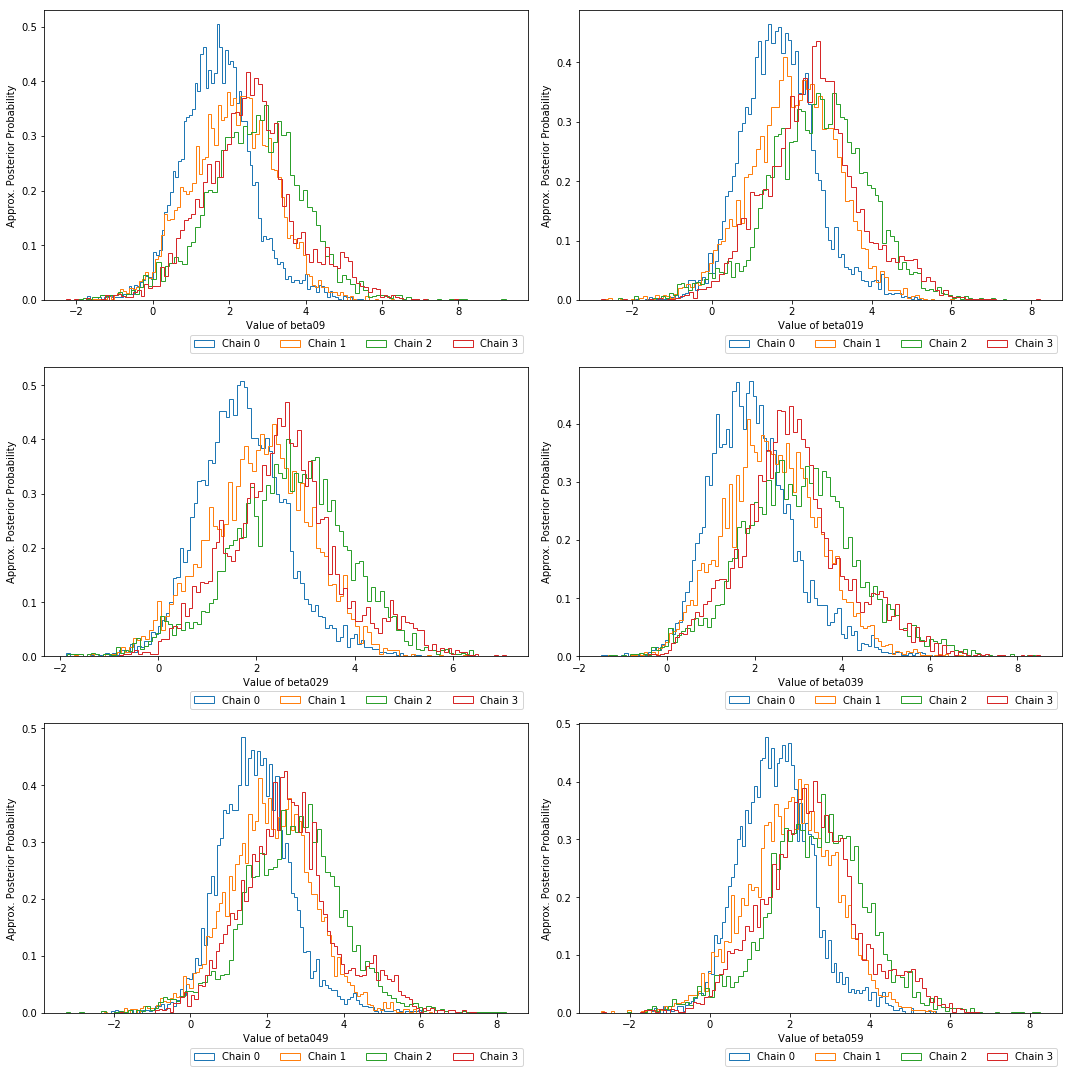

In [78]:
beta_lst=['beta09','beta019','beta029', 'beta039','beta049','beta059']

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
axs = [ax1, ax2, ax3, ax4, ax5, ax6]
for i, val in enumerate(beta_lst):  
    for cur_chain in range(num_chains):
        axs[i].hist(chain_df_list[cur_chain][val], bins=100, histtype='step', density=True, label="Chain {}".format(cur_chain));
    axs[i].set_xlabel(str("Value of "+val))
    axs[i].set_ylabel("Approx. Posterior Probability")
    axs[i].legend(loc=4, bbox_to_anchor=(1, -0.2), ncol=5)
    plt.tight_layout()

**Answer**

The samples don't seem to converge quickly on simulated data, but we see that all the beta0 are centered around 2 which was mean of the beta0 in the simulated data. 

In [21]:
def convert_to_dfs(samples, parameter_names, num_chains):
    """Converts a pyjags sampling result to a list of data frames, one per chain"""
    big_list = []
    for cur_chain_num in range(num_chains):
        df_list = []
        for k in parameter_names:
            v = samples[k]

            chain1_data = v[:,:,cur_chain_num]
            cur_df = pd.DataFrame(chain1_data.T)
            
            if cur_df.shape[1]==1:
                cur_df = cur_df.rename({1:k}, axis=1)
            else:
                cur_df = cur_df.add_prefix(k)
                
            df_list.append(cur_df)

        chain1_samples_df = pd.concat(df_list, axis=1)
        big_list.append(chain1_samples_df)
        
    return big_list

chain_df_list = convert_to_dfs(samples_simulated,["beta0"],num_chains)

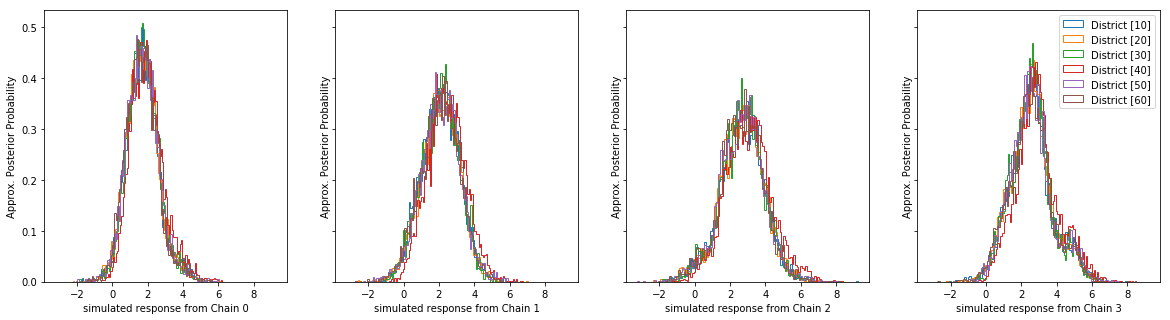

In [22]:
fig, ax = plt.subplots(1, num_chains, figsize=(20,5), sharex=True, sharey=True)

for cur_chain in range(num_chains):
    ax[cur_chain].set_xlabel("simulated response from Chain {}".format(cur_chain))
    ax[cur_chain].set_ylabel("Approx. Posterior Probability".format(cur_chain))
    for i in range(9, 60, 10):
        cur_name = 'beta0'+str(i)
        all_y_n = samples_simulated['beta0'][i,:,:]
        ax[cur_chain].hist(chain_df_list[cur_chain][cur_name], 
                            bins=100, 
                            histtype='step', 
                            label="District {}".format([i+1]),
                            density=True
                            )
        
plt.legend()
plt.show()

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [23]:
## for actual code

bwomen_model_code = '''
model {    
    mu0 ~ dnorm(0, 1/10000);
    inv_sigma0 ~ dgamma(.1,.1);
    
    for (j in 1:J){
        b0[j] ~ dnorm(mu0, inv_sigma0)
    }
    
    b1 ~ dnorm(0, 1/10000);
    b2 ~ dnorm(0, 1/10000);
    b3 ~ dnorm(0, 1/10000);
    
    
    for (i in 1:N){
        linpred[i] = b0[id[i]] + b1*x1[i] + b2*x2[i] + b3*x3[i];
        p[i] = ilogit(linpred[i]);
        yhat[i] = p[i];
        y[i] ~ dbern(p[i]);
      }
 }
'''

In [24]:
## for actual code

flatten = lambda l: [item for sublist in l for item in sublist]
id = flatten(np.array(df_train[['district']]))

observed_vals = {'y': df_train['contraceptive_use'],
                 'x1': df_train['urban'],
                 'x2': df_train['living.children'],
                 'x3': df_train['age_mean'],
                 'J': len(df_train.district.unique()),
                 'id': id,
                 'N': df_train.shape[0]}



num_chains = 4
bwomen_model = pyjags.Model(bwomen_model_code, data=observed_vals, chains=num_chains)
burnin = bwomen_model.sample(1000)     #warmup/burn-in
samples = bwomen_model.sample(5000)   #samples

adapting: iterations 1324 of 4000, elapsed 0:00:05, remaining 0:00:11
adapting: iterations 3828 of 4000, elapsed 0:00:15, remaining 0:00:01
adapting: iterations 4000 of 4000, elapsed 0:00:16, remaining 0:00:00
sampling: iterations 2388 of 4000, elapsed 0:00:10, remaining 0:00:07
sampling: iterations 4000 of 4000, elapsed 0:00:16, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:16, remaining 0:00:00
sampling: iterations 2304 of 20000, elapsed 0:00:09, remaining 0:01:12
sampling: iterations 3532 of 20000, elapsed 0:00:14, remaining 0:01:07
sampling: iterations 4756 of 20000, elapsed 0:00:19, remaining 0:01:02
sampling: iterations 7200 of 20000, elapsed 0:00:29, remaining 0:00:52
sampling: iterations 8424 of 20000, elapsed 0:00:34, remaining 0:00:47
sampling: iterations 10864 of 20000, elapsed 0:00:44, remaining 0:00:37
sampling: iterations 13312 of 20000, elapsed 0:00:54, remaining 0:00:27
sampling: iterations 15760 of 20000, elapsed 0:01:04, remaining 0:00:17
sampling:

your response here

Check the convergence by examining the trace plots, as you did with the simulated data. What do you observe?

In [25]:
for key, val in enumerate(samples):
    print(key, val)

0 J
1 N
2 b0
3 b1
4 b2
5 b3
6 id
7 inv_sigma0
8 linpred
9 mu0
10 p
11 x1
12 x2
13 x3
14 y
15 yhat


In [26]:
# We have inverse sigma or variance on running the pyjags model
sigmab0 = np.reciprocal(np.sqrt(samples['inv_sigma0']))
samples['sigmab0'] = sigmab0

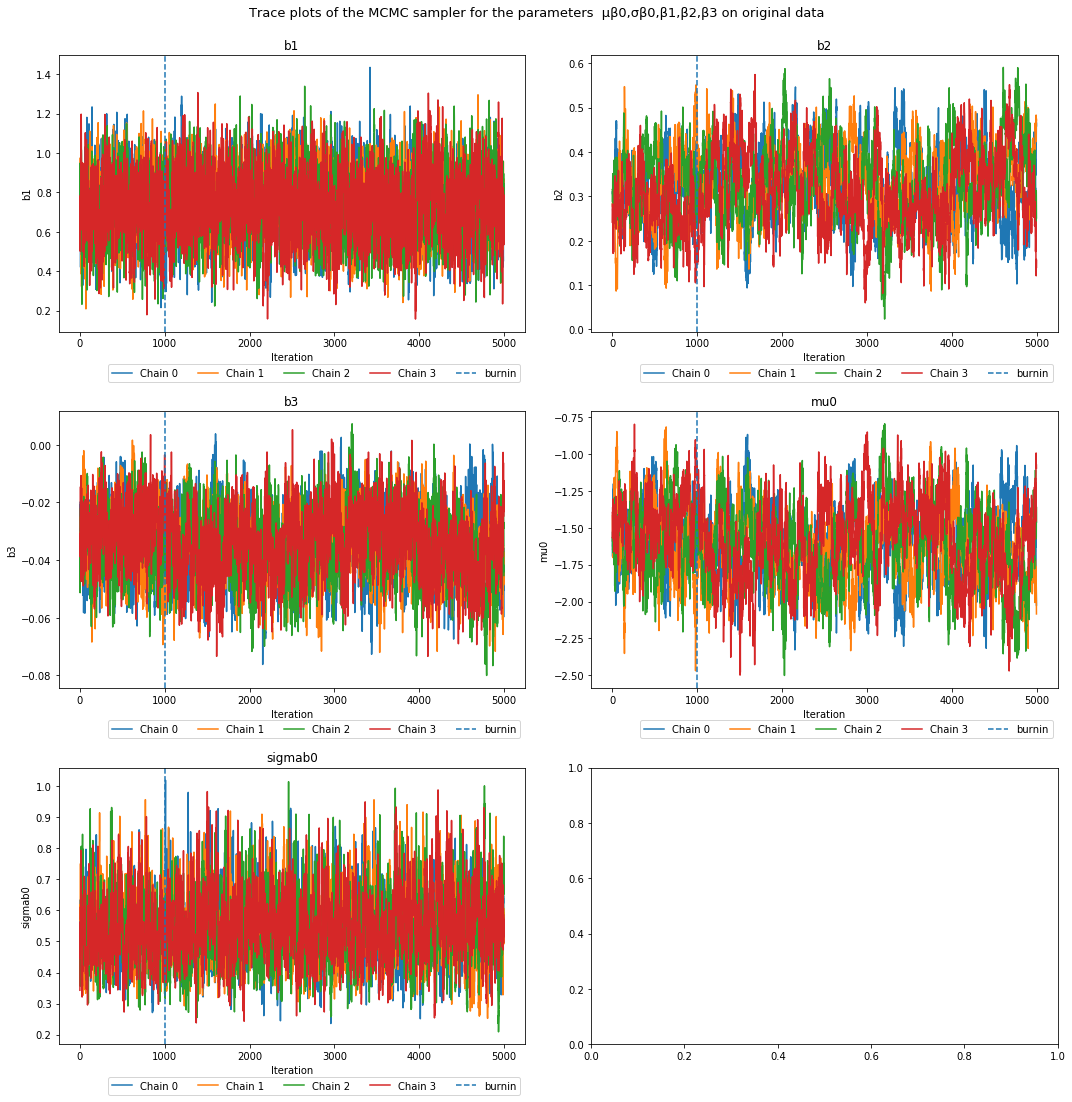

In [82]:
#trace plots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15,15))
axs=[ax1,ax2,ax3,ax4,ax5,ax6]
y_param = ['b1', 'b2', 'b3', 'mu0', 'sigmab0']

fig.suptitle('Trace plots of the MCMC sampler for the parameters  μβ0,σβ0,β1,β2,β3 on original data', 
             fontsize=13, va='top', y=1.02)
for i in range(5):
    axs[i]=plot_trace(samples, y_param[i], y_param[i], i, burnin_param=1000)

**Answer**

We observe that when we run model with real data, they seem to converge quickly compared to the simulated data.

In [28]:
def convert_to_dfs1(samples, parameter_names, num_chains):
    """Converts a pyjags sampling result to a list of data frames, one per chain"""
    big_list = []
    for cur_chain_num in range(num_chains):
        df_list = []
        for k in parameter_names:
            v = samples[k]

            chain1_data = v[:,:,cur_chain_num]
            cur_df = pd.DataFrame(chain1_data.T)

            if cur_df.shape[1]==1:
                cur_df = cur_df.rename({0:k}, axis=1)
            else:
                cur_df = cur_df.add_prefix(k)

            df_list.append(cur_df)

        chain1_samples_df = pd.concat(df_list, axis=1)
        big_list.append(chain1_samples_df)
        
    return big_list

In [29]:
chain_df_var_incpt = convert_to_dfs1(samples,['b0', 'b1','b2','b3'], 4)

bwomen_chain1_mcmc = r_coda.mcmc(pandas2ri.py2ri(chain_df_var_incpt[0]))
bwomen_chain2_mcmc = r_coda.mcmc(pandas2ri.py2ri(chain_df_var_incpt[1]))
bwomen_chain3_mcmc = r_coda.mcmc(pandas2ri.py2ri(chain_df_var_incpt[2]))
bwomen_chain4_mcmc = r_coda.mcmc(pandas2ri.py2ri(chain_df_var_incpt[3]))

bwomen_chains=r_coda.mcmc_list(bwomen_chain1_mcmc,bwomen_chain2_mcmc,bwomen_chain3_mcmc,bwomen_chain4_mcmc)

#get n_eff and Rhat
bwomen_n_eff = np.round(np.array(r_coda.effectiveSize(bwomen_chains))) #round because must be an integer
bwomen_rhat = np.array(r_coda.gelman_diag(bwomen_chains).rx2("psrf"))

bwomen_rhat = np.array([bwomen_rhat[i][0] for i in range(63)]) #extract point estimates


#calculate summary
bwomen_b0_summary = [[np.mean(samples['b0'][i]),np.std(samples['b0'][i])] for i in range(60)]
bwomen_b1_summary = [np.mean(samples['b1'][0]),np.std(samples['b1'][0])]
bwomen_b2_summary = [np.mean(samples['b2'][0]),np.std(samples['b2'][0])]
bwomen_b3_summary = [np.mean(samples['b3'][0]),np.std(samples['b3'][0])]

for i in [0.025,0.25,0.5,0.75,0.975]:
    for j in range(60):
        bwomen_b0_summary[j].append(np.quantile(samples['b0'][j],i))
    bwomen_b1_summary.append(np.quantile(samples['b1'],i))
    bwomen_b2_summary.append(np.quantile(samples['b2'],i))
    bwomen_b3_summary.append(np.quantile(samples['b3'],i))
    
for j in range(60):
    bwomen_b0_summary[j].append(bwomen_n_eff[j])
    bwomen_b0_summary[j].append(bwomen_rhat[j])
    
bwomen_b1_summary.append(bwomen_n_eff[60])
bwomen_b1_summary.append(bwomen_rhat[60])

bwomen_b2_summary.append(bwomen_n_eff[61])
bwomen_b2_summary.append(bwomen_rhat[61])

bwomen_b3_summary.append(bwomen_n_eff[62])
bwomen_b3_summary.append(bwomen_rhat[62])

coef_b_summary=[bwomen_b1_summary, bwomen_b2_summary, bwomen_b3_summary]

In [30]:
bwomen_summary = pd.DataFrame(bwomen_b0_summary+coef_b_summary,
                              columns=["mean","sd","2.5%","25%","50%","75%","97.5%","n_eff","Rhat"],
                             index=['b0_'+str(i+1) for i in range(60)]+['b1','b2','b3'])

In [31]:
bwomen_summary.head()

,mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
b0_1,-2.128498,0.368252,-2.856278,-2.371277,-2.128657,-1.877306,-1.417542,674.0,1.013030
b0_2,-1.778080,0.484809,-2.782405,-2.087916,-1.765549,-1.453679,-0.865018,1083.0,1.007892
b0_3,-1.503615,0.591202,-2.653763,-1.895097,-1.504766,-1.114303,-0.337018,2347.0,1.004417
b0_4,-1.439411,0.468474,-2.353391,-1.752320,-1.434858,-1.127305,-0.535988,1095.0,1.009831
b0_5,-1.603443,0.467045,-2.525391,-1.911248,-1.598264,-1.292486,-0.683175,1262.0,1.006167


In [32]:
bwomen_summary.tail()

,mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
b0_59,-1.848017,0.538791,-2.949674,-2.194680,-1.832071,-1.486286,-0.827568,1446.0,1.006540
b0_60,-2.069839,0.488299,-3.057297,-2.392767,-2.054931,-1.736251,-1.145968,1404.0,1.006008
b1,0.739369,0.162967,0.417298,0.629143,0.739431,0.849909,1.057756,4086.0,1.003306
b2,0.323899,0.081593,0.163467,0.267198,0.323401,0.381206,0.480300,324.0,1.023233
b3,-0.034779,0.011408,-0.057359,-0.042446,-0.034682,-0.027027,-0.012819,631.0,1.011993


In [33]:
print('Rhat_range is from', bwomen_summary['Rhat'].min(), "to ", bwomen_summary['Rhat'].max())

Rhat_range is from 1.0032794037174813 to  1.0232330188105914


**Answer**<br>
Since the Rhat value is close to 1.00 we can infer the MCMC has converged. 
Trace plots for beta0, beta1, beta3 and sigma beta0 have fully converged, while beta2 and mu0 are almost converged.

Based on the posterior means, women belonging to which district are most likely to use contraceptives? Women belonging to which district are least likely to use contraceptives?

In [34]:
J=60
b0=[np.mean(samples['b0'][i]) for i in range(J)]
b1=bwomen_summary.loc['b1', 'mean']
b2=bwomen_summary.loc['b2', 'mean']
b3=bwomen_summary.loc['b3', 'mean']


def var_incpt_score(row):
    for i in range(J):
        if row['district']== i+1:
            linpred=b0[i]+b1*row['urban']+b2*row['living.children']+b3*row['age_mean']  
            p_est=expit(linpred)
    return p_est

df_train['p_est_incpt']=df_train.apply(var_incpt_score,axis=1)
df_train['p_est_incpt'].min(), df_train['p_est_incpt'].max()
df_train['y_est_incpt'] = np.random.binomial(1, df_train['p_est_incpt'])

In [35]:
df_train.head()

,district,urban,living.children,age_mean,contraceptive_use,p_est,y_sim,p_est_incpt,y_est_incpt
0,35,0,4,2.4400,0,3.256569e-07,0,0.469548,0
1,22,0,2,-1.5599,1,1.709530e-01,0,0.273453,0
2,29,0,2,-8.5599,1,9.999967e-01,1,0.303433,0
3,5,0,3,-4.5599,1,7.586251e-01,0,0.383869,1
4,34,1,4,8.4400,0,6.501264e-11,0,0.702327,0


In [36]:
y_incpt_district=df_train.groupby('district')['y_est_incpt'].mean()
y_incpt_district.idxmax(),y_incpt_district.idxmin()

(3, 7)

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(df_train.contraceptive_use, df_train.y_est_incpt)

0.5791106514994829

In [38]:
from sklearn.metrics import classification_report
print(classification_report(df_train.contraceptive_use, df_train.y_est_incpt))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       590
           1       0.46      0.44      0.45       377

   micro avg       0.58      0.58      0.58       967
   macro avg       0.55      0.55      0.55       967
weighted avg       0.58      0.58      0.58       967



**Answer**<br>
Posterior means estimate is maximum for district 26, hence this district is most likely to use contraceptives. While the minimum estimate is for district 3 which is least likely to use contraceptives.
<br><br>
We computed the average accuracy score for our predctions which is around 54% and we computed classification matrix for our predictions with a precision of 0.42 and recall of 0.44 on using contraceptives.

What are the posterior means of $\mu_{\beta_0}$ and $\sigma^2_{\beta_0}$? Do these values offer any evidence in support of or against the varying-intercept model?

In [39]:
print("Posterior mean of μβ0 is ",np.mean(samples['mu0']))
print("Posterior mean of σ2β0 is ",np.mean(np.reciprocal(samples['inv_sigma0'])))

Posterior mean of μβ0 is  -1.6072133903387054
Posterior mean of σ2β0 is  0.30079007963479815


**Answer**<br>
We observe that intercept has a very low variance of 0.3 and it is centered around mean of -1.627 That means beta0 (intercept) is not different for different districts. Hence, it doesn't support the varying-intercept model.

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [40]:
## Varying coefficients model for real data

bwomen_model_code_vcoe = '''
model {

mu0 ~ dnorm(0,1/10000);
inv_sigma0 ~ dgamma(.1,.1);
inv_sigma1 ~ dgamma(.1,.1);
inv_sigma2 ~ dgamma(.1,.1);
inv_sigma3 ~ dgamma(.1,.1);

  for (j in 1:J){
    b0[j] ~ dnorm(mu0, inv_sigma0) ;
    b1[j] ~ dnorm(0,inv_sigma1);
    b2[j] ~ dnorm(0,inv_sigma2);
    b3[j] ~ dnorm(0,inv_sigma3);
   }

  for (i in 1:N){
    linpred[i] = b0[id[i]] + b1[id[i]]*x1[i] + b2[id[i]]*x2[i] + b3[id[i]]*x3[i];
    p[i] = ilogit(linpred[i]);
    yhat[i] = p[i];
     y[i] ~ dbern(p[i]);
  }
  

}
'''

In [41]:
## Varying coefficients model for real data

id = flatten(np.array(df_train[['district']]))

observed_vals = {'x1': df_train['urban'],
                 'x2': df_train['living.children'],
                 'x3': df_train['age_mean'],
                 'y': df_train['contraceptive_use'],
                 'J': len(df_train.district.unique()),
                 'id': id,
                 'N': df_train.shape[0]}

num_chains = 4
bwomen_model_vcoe = pyjags.Model(bwomen_model_code_vcoe, data=observed_vals, chains=num_chains)
burnin = bwomen_model_vcoe.sample(1000)     #warmup/burn-in
samples_vcoe = bwomen_model_vcoe.sample(5000)   #samples

adapting: iterations 2296 of 4000, elapsed 0:00:06, remaining 0:00:04
adapting: iterations 4000 of 4000, elapsed 0:00:10, remaining 0:00:00
sampling: iterations 3656 of 4000, elapsed 0:00:10, remaining 0:00:01
sampling: iterations 4000 of 4000, elapsed 0:00:10, remaining 0:00:00
sampling: iterations 3656 of 20000, elapsed 0:00:10, remaining 0:00:43
sampling: iterations 7492 of 20000, elapsed 0:00:20, remaining 0:00:33
sampling: iterations 9404 of 20000, elapsed 0:00:25, remaining 0:00:28
sampling: iterations 13216 of 20000, elapsed 0:00:35, remaining 0:00:18
sampling: iterations 15124 of 20000, elapsed 0:00:40, remaining 0:00:13
sampling: iterations 17032 of 20000, elapsed 0:00:45, remaining 0:00:08
sampling: iterations 20000 of 20000, elapsed 0:00:53, remaining 0:00:00
sampling: iterations 20000 of 20000, elapsed 0:00:53, remaining 0:00:00


In [42]:
J = len(df_train.district.unique())
chain_df_bwomen = convert_to_dfs1(samples_vcoe,['b0', 'b1','b2','b3'],4)

bwomen_vcoe_chain1_mcmc = r_coda.mcmc(pandas2ri.py2ri(chain_df_bwomen[0]))
bwomen_vcoe_chain2_mcmc = r_coda.mcmc(pandas2ri.py2ri(chain_df_bwomen[1]))
bwomen_vcoe_chain3_mcmc = r_coda.mcmc(pandas2ri.py2ri(chain_df_bwomen[2]))
bwomen_vcoe_chain4_mcmc = r_coda.mcmc(pandas2ri.py2ri(chain_df_bwomen[3]))

#convert to mcmc_list object
bwomen_vcoe_chains=r_coda.mcmc_list(bwomen_vcoe_chain1_mcmc,bwomen_vcoe_chain2_mcmc,bwomen_vcoe_chain3_mcmc,bwomen_vcoe_chain4_mcmc)

bwomen_vcoe_n_eff = np.round(np.array(r_coda.effectiveSize(bwomen_vcoe_chains))) #round because must be an integer
bwomen_vcoe_rhat = np.array(r_coda.gelman_diag(bwomen_vcoe_chains).rx2("psrf"))
bwomen_vcoe_rhat = np.array([bwomen_vcoe_rhat[i][0] for i in range(240)]) #extract point estimates


bwomen_vcoe_b0_summary = [[np.mean(samples_vcoe['b0'][i]),np.std(samples_vcoe['b0'][i])] for i in range(J)]
bwomen_vcoe_b1_summary = [[np.mean(samples_vcoe['b1'][i]),np.std(samples_vcoe['b1'][i])] for i in range(J)]
bwomen_vcoe_b2_summary = [[np.mean(samples_vcoe['b2'][i]),np.std(samples_vcoe['b2'][i])] for i in range(J)]
bwomen_vcoe_b3_summary = [[np.mean(samples_vcoe['b3'][i]),np.std(samples_vcoe['b3'][i])] for i in range(J)]

for i in [0.025,0.25,0.5,0.75,0.975]:
    for j in range(J):
        bwomen_vcoe_b0_summary[j].append(np.quantile(samples_vcoe['b0'][j],i))
        bwomen_vcoe_b1_summary[j].append(np.quantile(samples_vcoe['b1'][j],i))
        bwomen_vcoe_b2_summary[j].append(np.quantile(samples_vcoe['b2'][j],i))
        bwomen_vcoe_b3_summary[j].append(np.quantile(samples_vcoe['b3'][j],i))

for j in range(J):
    bwomen_vcoe_b0_summary[j].append(bwomen_vcoe_n_eff[j])
    bwomen_vcoe_b0_summary[j].append(bwomen_vcoe_rhat[j])
    bwomen_vcoe_b1_summary[j].append(bwomen_vcoe_n_eff[j])
    bwomen_vcoe_b1_summary[j].append(bwomen_vcoe_rhat[j])
    bwomen_vcoe_b2_summary[j].append(bwomen_vcoe_n_eff[j])
    bwomen_vcoe_b2_summary[j].append(bwomen_vcoe_rhat[j])
    bwomen_vcoe_b3_summary[j].append(bwomen_vcoe_n_eff[j])
    bwomen_vcoe_b3_summary[j].append(bwomen_vcoe_rhat[j])
        
bwomen_vcoe_summary = pd.DataFrame(bwomen_vcoe_b0_summary+bwomen_vcoe_b1_summary+bwomen_vcoe_b2_summary+bwomen_vcoe_b3_summary,
                                  columns=["mean","sd","2.5%","25%","50%","75%","97.5%","n_eff","Rhat"],
                                  index=['b0'+str(i+1) for i in range(J)]+['b1'+str(i+1) for i in range(J)]
                                        +['b2'+str(i+1) for i in range(J)]+['b3'+str(i+1) for i in range(J)])
bwomen_vcoe_summary.head()

,mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
b01,-0.943575,0.394602,-1.770625,-1.191352,-0.925033,-0.679253,-0.211586,3005.0,1.007457
b02,-0.867234,0.432216,-1.754697,-1.136164,-0.860331,-0.593958,-0.023601,4800.0,1.001969
b03,-0.690602,0.487303,-1.631951,-0.993135,-0.710602,-0.405642,0.364070,5158.0,1.001265
b04,-0.676916,0.434895,-1.502741,-0.959349,-0.688215,-0.411593,0.232791,3881.0,1.001594
b05,-0.830399,0.416938,-1.665203,-1.092659,-0.827566,-0.563637,0.001540,5632.0,1.003053


In [43]:
bwomen_vcoe_summary.tail()

,mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
b356,-0.020359,0.046289,-0.112231,-0.051170,-0.020204,0.011132,0.070076,1188.0,1.006087
b357,0.041338,0.064603,-0.085928,-0.000940,0.041843,0.084475,0.167033,2958.0,1.004102
b358,0.031148,0.046899,-0.059454,-0.000276,0.030557,0.062198,0.124795,3975.0,1.002384
b359,-0.031671,0.070089,-0.169220,-0.077455,-0.031253,0.015180,0.104588,5377.0,1.007378
b360,0.043692,0.070442,-0.089817,-0.004397,0.042442,0.089941,0.187591,3317.0,1.004517


In [44]:
print('Rhat_range is from', bwomen_vcoe_summary['Rhat'].min(), "to ", bwomen_vcoe_summary['Rhat'].max())

Rhat_range is from 1.0012602232332397 to  1.013432242885193


**Answer**<br>
Rhat values for all the coeffients are very close to 1 (1.0002, 1.0102). that is, the samples are converging. We can use the sample mean of coefficients as estimated coefficients for the model.

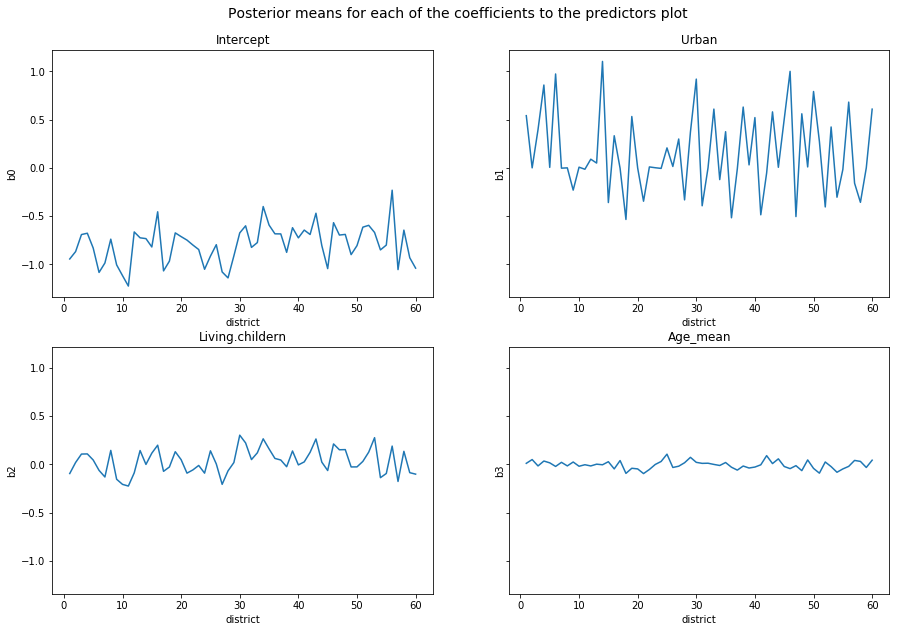

In [45]:
b0=[np.mean(samples_vcoe['b0'][i]) for i in range(J)]
b1=[np.mean(samples_vcoe['b1'][i]) for i in range(J)]
b2=[np.mean(samples_vcoe['b2'][i]) for i in range(J)]
b3=[np.mean(samples_vcoe['b3'][i]) for i in range(J)]

x=[i+1 for i in range(60)]
y=[b0,b1,b2,b3]
title =['Intercept', 'Urban', 'Living.childern', 'Age_mean']
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10), sharey=True)
fig.suptitle('Posterior means for each of the coefficients to the predictors plot', y=0.94, fontsize=14) 
axs=[ax1,ax2,ax3,ax4]

for i in range(4):
    axs[i].plot(x,y[i])
    axs[i].set_title(title[i], fontsize=12)
    axs[i].set_xlabel('district', fontsize=10)
    axs[i].set_ylabel('b'+str(i), fontsize=10)

**Answer**<br>

We observe that there is more variation within districts in posterior mean coefficients for the predictor 'Urban' and least variation for the predictor 'Age_mean'. While the predictor 'Living.Children' and the intercept have little variation. 
<br>
We could retain the varying coefficients concept for the predictors 'Urban', 'Living.Children' and for intercept. While we could remove the varying coefficients concept for the predictor 'Age_mean'  in our model.

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [46]:
## our final model built on train data

final_model = '''
model {

mu0 ~ dnorm(0,1/10000);
inv_sigma0 ~ dgamma(.1,.1);
inv_sigma1 ~ dgamma(.1,.1);
inv_sigma2 ~ dgamma(.1,.1);
b3 ~ dnorm(0,1/10000);

  for (j in 1:J){
    b0[j] ~ dnorm(mu0, inv_sigma0) ;
    b1[j] ~ dnorm(0,inv_sigma1);
    b2[j] ~ dnorm(0,inv_sigma2);
    }

  for (i in 1:N){
    linpred[i] = b0[id[i]] + b1[id[i]]*x1[i] + b2[id[i]]*x2[i] + b3*x3[i];
    p[i] = ilogit(linpred[i]);
    yhat[i] = p[i];
     y[i] ~ dbern(p[i]);
  }
  

}
'''

In [47]:
## our final model built on train data

id = flatten(np.array(df_train[['district']]))

observed_vals = {'x1': df_train['urban'],
                 'x2': df_train['living.children'],
                 'x3': df_train['age_mean'],
                 'y': df_train['contraceptive_use'],
                 'J': len(df_train.district.unique()),
                 'id': id,
                 'N': df_train.shape[0]}

num_chains = 4
final_model_vcoe = pyjags.Model(final_model, data=observed_vals, chains=num_chains)
burnin = final_model_vcoe.sample(1000)     #warmup/burn-in
final_model_samples = final_model_vcoe.sample(5000)   #samples

adapting: iterations 3164 of 4000, elapsed 0:00:09, remaining 0:00:02
adapting: iterations 4000 of 4000, elapsed 0:00:11, remaining 0:00:00
sampling: iterations 3276 of 4000, elapsed 0:00:10, remaining 0:00:02
sampling: iterations 4000 of 4000, elapsed 0:00:12, remaining 0:00:00
sampling: iterations 3348 of 20000, elapsed 0:00:10, remaining 0:00:48
sampling: iterations 5064 of 20000, elapsed 0:00:15, remaining 0:00:44
sampling: iterations 8480 of 20000, elapsed 0:00:25, remaining 0:00:34
sampling: iterations 11896 of 20000, elapsed 0:00:35, remaining 0:00:24
sampling: iterations 15324 of 20000, elapsed 0:00:45, remaining 0:00:14
sampling: iterations 17040 of 20000, elapsed 0:00:50, remaining 0:00:09
sampling: iterations 20000 of 20000, elapsed 0:00:58, remaining 0:00:00
sampling: iterations 20000 of 20000, elapsed 0:00:58, remaining 0:00:00


In [48]:
df_test=pd.read_csv('dataset_2_test.csv')
df_test['district']=np.where(df_test['district']==61,54,df_test['district'])
df_test.head()

,district,urban,living.children,age_mean,contraceptive_use
0,1,1,4,18.4400,0
1,1,1,1,-5.5599,0
2,1,1,4,8.4400,0
3,1,1,2,-5.5599,0
4,1,1,4,1.4400,0


In [49]:
b0=[np.mean(final_model_samples['b0'][i]) for i in range(J)]
b1=[np.mean(final_model_samples['b1'][i]) for i in range(J)]
b2=[np.mean(final_model_samples['b2'][i]) for i in range(J)]
b3=[np.mean(final_model_samples['b3'])]

from scipy.special import expit, logit

def var_coe_score(row):
    for i in range(60):
        if row['district']== i+1:
            linpred=b0[i]+b1[i]*row['urban']+b2[i]*row['living.children']+b3[0]*row['age_mean']  
            p_est=expit(linpred)
    return p_est

df_test['p_est_final']=df_test.apply(var_coe_score,axis=1)
df_test['p_est_final'].min(), df_test['p_est_final'].max()

(0.12598626477629182, 0.7866233345386175)

In [50]:
df_test['y_est_final'] = np.random.binomial(1, df_test['p_est_final'])

In [51]:
print("Classification percentage for test data is {:.2%}".format(df_test['y_est_final'].mean()))

print("Classification Accuracy for test data is {:.2%}".format(accuracy_score(df_test.contraceptive_use, df_test.y_est_final)))

Classification percentage for test data is 37.23%
Classification Accuracy for test data is 54.91%


In [52]:
print("Classification Report using precision and recall")
print(classification_report(df_test.contraceptive_use, df_test.y_est_final))

Classification Report using precision and recall
              precision    recall  f1-score   support

           0       0.62      0.65      0.63       585
           1       0.42      0.40      0.41       382

   micro avg       0.55      0.55      0.55       967
   macro avg       0.52      0.52      0.52       967
weighted avg       0.54      0.55      0.55       967



your response here